# Text classification

- Assign input text into categories (classes):
  - Filtering (e.g. spam / non-spam)
  - Topic identification (e.g. politics, sports, business)
  - Sentiment analysis (positive / negative / neutral)
  - Language identification (Finnish, English, ...)
  - Authorship attribution (who wrote this text?)
  - (and many more)
  
---  

**Example**: classify each of the following email subject lines as `spam` or `ham` (non-spam)

```
  Subject: want to make more money ?
  Subject: during / after hours contact information
  Subject: learn to save on medications at discount pharmacy
  Subject: invitation to dinner
  Subject: your 60 second auto loan will be accepted
  Subject: diet medications online
  Subject: december preliminary production estimate
  Subject: first deliveries - comstock oil & gas and united oil & mineral
```

# Learning to classify text
  
- In this lesson, focus on **supervised** classification
  - We assume a *training set* of example inputs (texts) with correct outputs (classes)
  - (Unsupervised classification (clustering) covered separately)
- Machine learning approach:
  - Given example texts and their classes $\textbf{y} = \{ y_1, y_2, \ldots y_n \}$
  - Represent each document as a feature vector $\textbf{x} = \{ x_1, x_2, \ldots x_n \}$  
  - Learn a function $f(X) \rightarrow Y$ to predict the class given text features
- Note: data is unordered, and there are no dependencies between texts (cf. sequence tagging)

### Overview

- Tokenization: split text into words (and non-word elements such as punctuation)
- Feature extraction: create discrete features representing the text
- Vectorization: map feature representation (human-readable) to vector form (machine-readable)
- Training: given vectorized training data and classes, train machine learning model
- Prediction: given vectorized text (or dev) data, predict classes
- Evaluation: compare predicted to true classes

# Spam classification

We'll use a version of the [Enron-Spam](http://www2.aueb.gr/users/ion/data/enron-spam/) corpus created by [Metsis et al. (2006)](http://nlp.cs.aueb.gr/pubs/ceas2006_paper.pdf) based on the [Enron email dataset](https://www.cs.cmu.edu/~./enron/) as an example text classification task.

First, let's have a look at the data.

In [12]:
import pandas as pd


def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)


text_data = pd.read_csv('data/enron-spam/enron-spam-subjects.tsv', sep='\t', names=('class', 'id', 'text'))
text_data = text_data[['class', 'text']]    # drop IDs

print(class_counts(text_data))

spam    16798
ham     16545


In [13]:
text_data[:5]

,class,text
0,spam,"what up , , your cam babe"
1,spam,want to make more money ?
2,spam,food for thoughts
3,spam,"miningnews . net newsletter - tuesday , januar..."
4,spam,your pharmacy ta


In [14]:
text_data[-5:]

,class,text
33338,ham,bullets 9 / 1
33339,ham,eog material
33340,ham,associate / analyst fall recruiting
33341,ham,tw bullets 1 / 26
33342,ham,dashboard enhancements


(Note that we're working with raw text: there are no lemmas, part-of-speech tags or similar.)

Split randomly into training, development and test sets. We'll again work on the training and development sets.

In [15]:
from sklearn.model_selection import train_test_split


train_texts, devel_and_test_texts = train_test_split(text_data, test_size=0.4, random_state=1234)
devel_texts, test_texts = train_test_split(devel_and_test_texts, test_size=0.5, random_state=5678)

for label, dataset in (('Training', train_texts),
                       ('Development', devel_texts),
                       ('Test', test_texts)):
    print('- {} -'.format(label))
    print(class_counts(dataset))
    print()

- Training -
spam    10071
ham      9934

- Development -
spam    3360
ham     3309

- Test -
spam    3367
ham     3302



## Feature representation

Machine learning methods do not understand text, so we need to represent it as features, using e.g.:

* Word forms, lemmas, parts-of-speech, and their combinations
* Word or character N-grams (pairs, triples, etc. of consecutive words/characters)
* Document metadata (author, time of creation, ...)
* ...

Simple document representation:

* Split text into words, create a feature for each (unique) word
* Note that this discards word order → no distinction between e.g. "man bites dog" and "dog bites man"
* *Bag-of-words* representations such as this often also encode the number of occurrences of each word
* This can be surprisingly effective: many things about texts can be learned even if you only know which words occur

In [16]:
from collections import Counter

from pprint import pprint as pretty_print


def word_features(text):
    features = {}
    for word in text.split():
        features[word] = True
    return features


def classes_and_features(dataset, featurizer=word_features):
    classes, feats = [], []
    for class_, text in dataset.values:
        classes.append(class_)
        feats.append(featurizer(text))
    return classes, feats


train_classes, train_data = classes_and_features(train_texts)
devel_classes, devel_data = classes_and_features(devel_texts)
test_classes, test_data = classes_and_features(test_texts)

pretty_print(list(train_texts.values[0]))
print()
pretty_print((train_classes[0], train_data[0]))

['spam', 'fw : upto 50 % off on prescrlpt 1 on drogs zgpxruoeyyimjhq e']

('spam',
 {'%': True,
  '1': True,
  '50': True,
  ':': True,
  'drogs': True,
  'e': True,
  'fw': True,
  'off': True,
  'on': True,
  'prescrlpt': True,
  'upto': True,
  'zgpxruoeyyimjhq': True})


## Reminder: Naive Bayes

* Simple probabilistic classifier based on class priors (`P(spam)`) and conditional feature probabilities (`P(viagra|spam)`)
* Estimate probabilities based on counts of classes and (feature, class) pairs in training data
    * Prior: `P(spam) = count(spam) / count(*)`
    * Conditional: `P(viagra|spam) = count(viagra, spam) / count(*, spam)`

In [17]:
from nltk import NaiveBayesClassifier


nb_classifier = NaiveBayesClassifier.train(zip(train_data, train_classes))

nb_classifier.show_most_informative_features(25)

Most Informative Features
                    2001 = True              ham : spam   =    143.8 : 1.0
                   meter = True              ham : spam   =    135.5 : 1.0
               interview = True              ham : spam   =     75.4 : 1.0
                 quality = True             spam : ham    =     70.0 : 1.0
                   group = True              ham : spam   =     63.2 : 1.0
                 revised = True              ham : spam   =     61.8 : 1.0
                       > = True             spam : ham    =     59.4 : 1.0
                       % = True             spam : ham    =     57.8 : 1.0
            presentation = True              ham : spam   =     57.1 : 1.0
                    2000 = True              ham : spam   =     56.4 : 1.0
              california = True              ham : spam   =     54.9 : 1.0
              nomination = True              ham : spam   =     54.9 : 1.0
                      em = True             spam : ham    =     54.9 : 1.0

In [18]:
from nltk import classify
from nltk.metrics import scores

pred_classes = nb_classifier.classify_many(devel_data)

print('{:.2%}'.format(scores.accuracy(devel_classes, pred_classes)))

93.04%


Looks OK, but accuracy is not very informative. Here we care very much about high recall, i.e. losing as few good (ham) emails as possible.

# Reminder: metrics

In the context of binary classification where one class is positive (e.g. `ham`) and the other negative (e.g. `spam`):

* Accuracy: fraction of predicted that are correct, i.e. identical to the true class
* Precision: fraction of predicted positives that are correct
* Recall: fraction of positives that were correctly predicted
* F-score: harmonic mean of precision and recall

More precisely

* True positives (**tp**): prediction **true** (i.e. correct), predicted class **positive**
* False negative (**fn**): prediction **false** (i.e. incorrect), predicted class **negative**
* True negative (**tn**): prediction **true**, predicted class **negative**
* False positive (**fp**): prediction **false**, predicted class **positive**

and

* Accuracy: (tp + tn)/(tp + fp + fn + tn)
* Precision (p): tp / (tp + fp)
* Recall (r): tp / (tp + fn)
* F-score: 2 * p * r / (p + r)

(Specifically, that's $F_1$-score, the balanced harmonic mean.)

Or, in code:

In [19]:
def counts(true_classes, pred_classes, positive_class='ham'):
    tp, fp, fn, tn = 0, 0, 0, 0
    for true, pred in zip(true_classes, pred_classes):
        if pred == true:
            if pred == positive_class:
                tp += 1
            else:
                tn += 1
        else:    # pred != true
            if pred == positive_class:
                fp += 1
            else:
                fn += 1
    return tp, fp, fn, tn

                
def accuracy(gold_classes, pred_classes):
    tp, fp, fn, tn = counts(gold_classes, pred_classes)
    return (tp + tn) / (tp + fp + fn + tn)


def precision(gold_classes, pred_classes, positive_class='ham'):
    tp, fp, fn, _ = counts(gold_classes, pred_classes, positive_class)
    return tp / (tp + fp)


def recall(gold_classes, pred_classes, positive_class='ham'):
    tp, fp, fn, _ = counts(gold_classes, pred_classes, positive_class)
    return tp / (tp + fn)


def f1_score(gold_classes, pred_classes, positive_class='ham'):
    p = precision(gold_classes, pred_classes, positive_class)
    r = recall(gold_classes, pred_classes, positive_class)
    return 2 * p * r / (p + r)


print('Accuracy :\t{:.2%}'.format(accuracy(devel_classes, pred_classes)))
print('Precision:\t{:.2%}'.format(precision(devel_classes, pred_classes)))
print('Recall   :\t{:.2%}'.format(recall(devel_classes, pred_classes)))
print('F-score  :\t{:.2%}'.format(f1_score(devel_classes, pred_classes)))

Accuracy :	93.04%
Precision:	94.49%
Recall   :	91.30%
F-score  :	92.87%


## Why not just accuracy?

Precision, recall and F-score are used in particular when positives are only a small fraction of the data. Consider e.g. an information retrieval setting where

* The total number of documents is 1000
* There are 10 documents about apples (the fruit)
* There are 20 documents about Apple (the company)
* Looking for information about fruit, a user queries two systems for "apple":
  - **System 1** returns nothing (it never does)
  - **System 2** returns the 10 fruit documents (positive) and the 20 Apple, Inc. documents (negative)
  
Evaluation:

* **System 1** accuracy: 990 / 1000 = 0.99
* **System 2** accuracy: 980 / 1000 = 0.98

But

* **System 1** precision, recall and F-score are zero
* **System 2** precision: 10 / 30 = 0.33
* **System 2** recall: 10 / 10 = 1.0
* **System 2** F-score: 0.5

The system that returns nothing has higher accuracy, but is performs lower in terms of precision, recall, and F-score.

---

# Support Vector Machines

* Machine learning method that finds (hyper)plane that optimally separates data
* Original formulation as linear classifier in 1963, non-linear extension in 1992
* Reasonably fast and highly competitive in many tasks, including text classification
* Simple case: separate points in 2D (can't visualize >10,000D) by finding plane with *maximum margin* to nearest points

<img src="https://upload.wikimedia.org/wikipedia/commons/2/20/Svm_separating_hyperplanes.png" width="35%">

<div style="text-align:center; color:gray; font-size:80%">(Figure from <a href="https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes.png">Wikimedia Commons</a>)</div>

* The method learns a weight vector **w** defining the orientation of the plane and a bias term $b$ defining its position

<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png" width="35%">

<div style="text-align:center; color:gray; font-size:80%">(Figure from <a href="https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes.png">Wikimedia Commons</a>)</div>

* Convex optimization problem (unique minimum) with efficient optimization methods (esp. linear time for linear SVM)
* The solution is determined by the points "supporting" the margin (hence the name)


In general, data may not be linearly separable, and a "hard" margin may not be optimal when if it is

* To address this, the soft-margin SVM formulation allows for some, i.e. points that are inside the margin
* Tradeoff between maximizing the margin and minimizing errors controlled by cost parameter C
    * (as $C \rightarrow \infty$, the solution apporaches a hard margin)

# SVM in practice

## Feature vectorization

* SVM implementations use integer indices (0, 1, 2, ...) to identify features
    * (The same goes for other methods we have used, but the ML libraries provided a transparent string mapping)
* Before training, we explicitly map our feature sets to vectors ("vectorize" the features)

In [20]:
import sklearn.svm
from sklearn.feature_extraction.text import CountVectorizer


def basic_tokenizer(txt):
    """Simple whitespace tokenizer"""
    return txt.split()


# Map texts to sparse matrix of token counts (bag-of-words)
# Here, vectorizer.fit() learns the vocabulary, and
# vectorizer.transform() performs the mapping.
# (There is also a combined fit_transform() function.)
vectorizer = CountVectorizer(tokenizer=basic_tokenizer)
vectorizer.fit(train_texts['text'])
train_X = vectorizer.transform(train_texts['text'])

feature_names = vectorizer.get_feature_names()

print('Examples from feature index ↔ name mapping:\n')
feature_num = train_X.shape[1]
for index in range(0, feature_num, int(feature_num/25)):
    print('{:6d} ↔ {}'.format(index, feature_names[index]))

Examples from feature index ↔ name mapping:

     0 ↔ !
   544 ↔ 53813
  1088 ↔ admin
  1632 ↔ arterial
  2176 ↔ blonde
  2720 ↔ ce
  3264 ↔ condescend
  3808 ↔ decertify
  4352 ↔ dummies
  4896 ↔ eveis
  5440 ↔ friedman
  5984 ↔ harvested
  6528 ↔ india
  7072 ↔ klno
  7616 ↔ luther
  8160 ↔ model
  8704 ↔ obligations
  9248 ↔ peer
  9792 ↔ print
 10336 ↔ regressions
 10880 ↔ scarify
 11424 ↔ solutions
 11968 ↔ tailgate
 12512 ↔ turned
 13056 ↔ ward
 13600 ↔ zpalx


In [21]:
print("texts x features: {}".format(train_X.shape))

train_X

texts x features: (20005, 13616)


<20005x13616 sparse matrix of type '<class 'numpy.int64'>'
	with 132462 stored elements in Compressed Sparse Row format>

* Each text has now been mapped to a long vector (rows of the matrix)
    * the dimensions correspond to words and the values to their counts in the text
* Note that almost all of the values will be zero: no text contains more than a small fraction of possible words

<img src="figs/bow_vector.png" width="60%">

<div style="text-align:center; font-size:80%">A vector representation of the sentence "a vector representation of a sentence"</div>

In [22]:
print('Feature indices and values for an examples sentence:\n')

for index in train_X[0].nonzero()[1]:
    print('{:6d}'.format(index), feature_names[index])

Feature indices and values for an examples sentence:

     4 %
    83 1
   509 50
   920 :
  4313 drogs
  4391 e
  5517 fw
  8742 off
  8813 on
  9747 prescrlpt
 12693 upto
 13575 zgpxruoeyyimjhq


In [23]:
from sklearn.svm import LinearSVC


svm_classifier = LinearSVC(max_iter=10000)
svm_classifier.fit(train_X, train_classes)    # note that classes are strings

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [24]:
devel_X = vectorizer.transform(devel_texts['text'])

pred_classes = svm_classifier.predict(devel_X)

# svm_classifier.score(devel_X, devel_classes)

print('Accuracy : {:.2%}'.format(accuracy(devel_classes, pred_classes)))
print('Precision: {:.2%}'.format(precision(devel_classes, pred_classes)))
print('Recall   : {:.2%}'.format(recall(devel_classes, pred_classes)))
print('F-score  : {:.2%}'.format(f1_score(devel_classes, pred_classes)))

Accuracy : 92.89%
Precision: 92.97%
Recall   : 92.69%
F-score  : 92.83%


Let's peek inside

In [25]:
import eli5


eli5.show_weights(svm_classifier, vec=vectorizer, top=50)

Weight?,Feature
+1.659,learn
+1.655,rolex
+1.553,money
+1.441,girls
+1.439,invite
+1.437,rotor
+1.433,404
+1.429,doctor
+1.426,1776
+1.417,impaired


(Note that only one class is shown as the task is binary: positive features for one class are negative for the other.)

## Hyperparameters and regularization

* Machine learning methods learn their primary parameters (e.g. feature weights) in training
* Most methods additionally have various *hyperparameters* that affect the model and training process
* Among the most important are regularization (hyper)parameters
* *Regularization* refers broadly to techiques that constrain a model to avoid overfitting
* Bias-variance tradeoff: a simple model may generalize better even if it doesn't fit the training data as well as a complex one

<img src="figs/bias-variance.png" width="60%">

<div style="text-align:center; font-size:80%">Illustration of bias and variance.</div>

Let's try this with the SVM regularization parameter C.

In [26]:
results = []
for C in (0.001, 0.01, 0.1, 1, 10, 100):
    svm_classifier = LinearSVC(C=C, max_iter=100000)
    svm_classifier.fit(train_X, train_classes)
    train_f = f1_score(train_classes, svm_classifier.predict(train_X))
    devel_f = f1_score(devel_classes, svm_classifier.predict(devel_X))
    print('C={:7.3f}, train F-score: {:.2%}, dev F-score: {:.2%}'.format(C, train_f, devel_f))
    results.append({ 'C': C, 'Train F': train_f, 'Devel F': devel_f })

C=  0.001, train F-score: 87.63%, dev F-score: 86.77%
C=  0.010, train F-score: 93.54%, dev F-score: 91.64%
C=  0.100, train F-score: 97.13%, dev F-score: 93.12%
C=  1.000, train F-score: 98.79%, dev F-score: 92.83%
C= 10.000, train F-score: 99.06%, dev F-score: 91.77%
C=100.000, train F-score: 99.17%, dev F-score: 90.00%


(Note when running this how training gets slower with higher values of C)

In [27]:
from pandas import DataFrame


result_data = DataFrame(results)
result_data

,C,Devel F,Train F
0,0.001,0.867690,0.876319
1,0.010,0.916439,0.935438
2,0.100,0.931191,0.971299
3,1.000,0.928269,0.987861
4,10.000,0.917686,0.990577
5,100.000,0.900045,0.991732


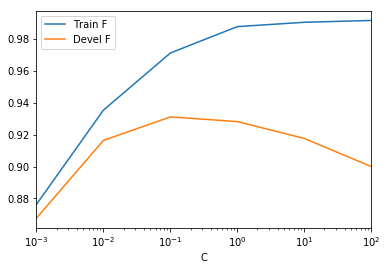

In [28]:
%matplotlib inline

result_data.plot(x='C', y=['Train F', 'Devel F'], logx=True) ;

This is a typical pattern:

* For small values of C, the SVM *underfits*: performance is low even on the training data
* For large values of C, it *overfits*: performance on training data gets close to 100%, but performance on unseen data drops

<img src="figs/regularization.png" width=50%>

<div style="text-align:center; font-size:80%">A better fit for training data (filled circles) does not guarantee generalization to unseen data (empty circles)</div>

## Feature weighting

* We have so far mostly glossed over the values associated with features, either using present/absent (1/0) or simple counts
* Features can be assigned any values, and weighting important features highly can help ML methods learn

### TF-IDF weighting

* Popular and effective statistic measuring the importance of word in a set of documents
* Term frequency (TF): count of word in current document (i.e. what we used above)
* Inverse Document Frequency (IDF): 1 / fraction of documents where word occurs

$$ TF\cdot\frac{N}{DF} $$

* $N$ is the total number of documents in the data
* $DF$ is the number of documents where word occurs

(Many variants of this basic scheme proposed and used.)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer


def test_vectorizer(train, test, Vectorizer, tokenizer=basic_tokenizer):
    vectorizer = Vectorizer(tokenizer=tokenizer)
    vectorizer.fit(train['text'])
    train_X = vectorizer.transform(train['text'])
    test_X = vectorizer.transform(test['text'])
    classifier = LinearSVC(C=1, max_iter=10000)
    classifier.fit(train_X, train['class'])
    pred_classes = classifier.predict(test_X)
    return f1_score(test['class'], pred_classes)


print('Count  F-score  : {:.2%}'.format(test_vectorizer(train_texts, devel_texts, CountVectorizer)))
print('TF-IDF F-score  : {:.2%}'.format(test_vectorizer(train_texts, devel_texts, TfidfVectorizer)))

Count  F-score  : 92.83%
TF-IDF F-score  : 93.56%


(To be continued ...)